In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter
import re
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



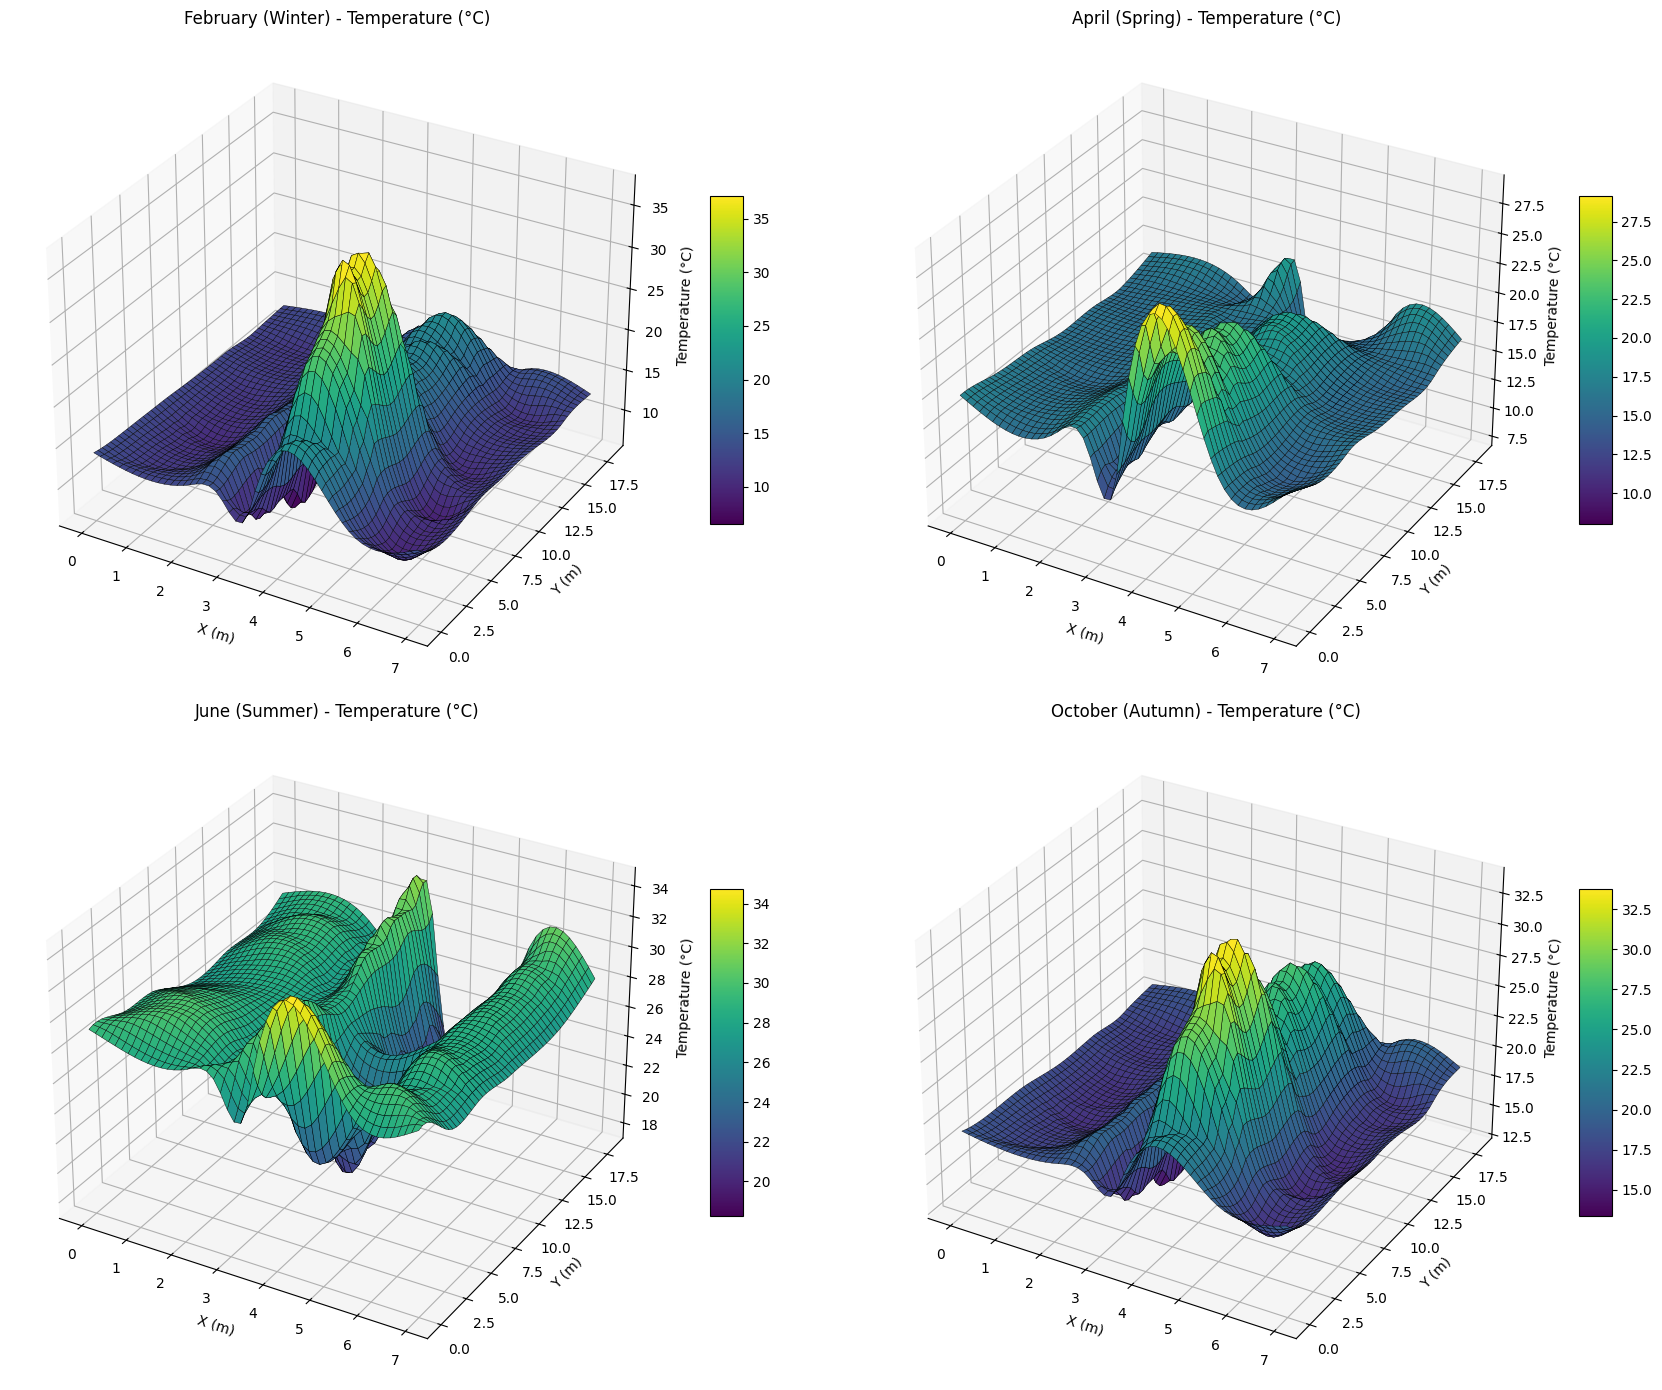

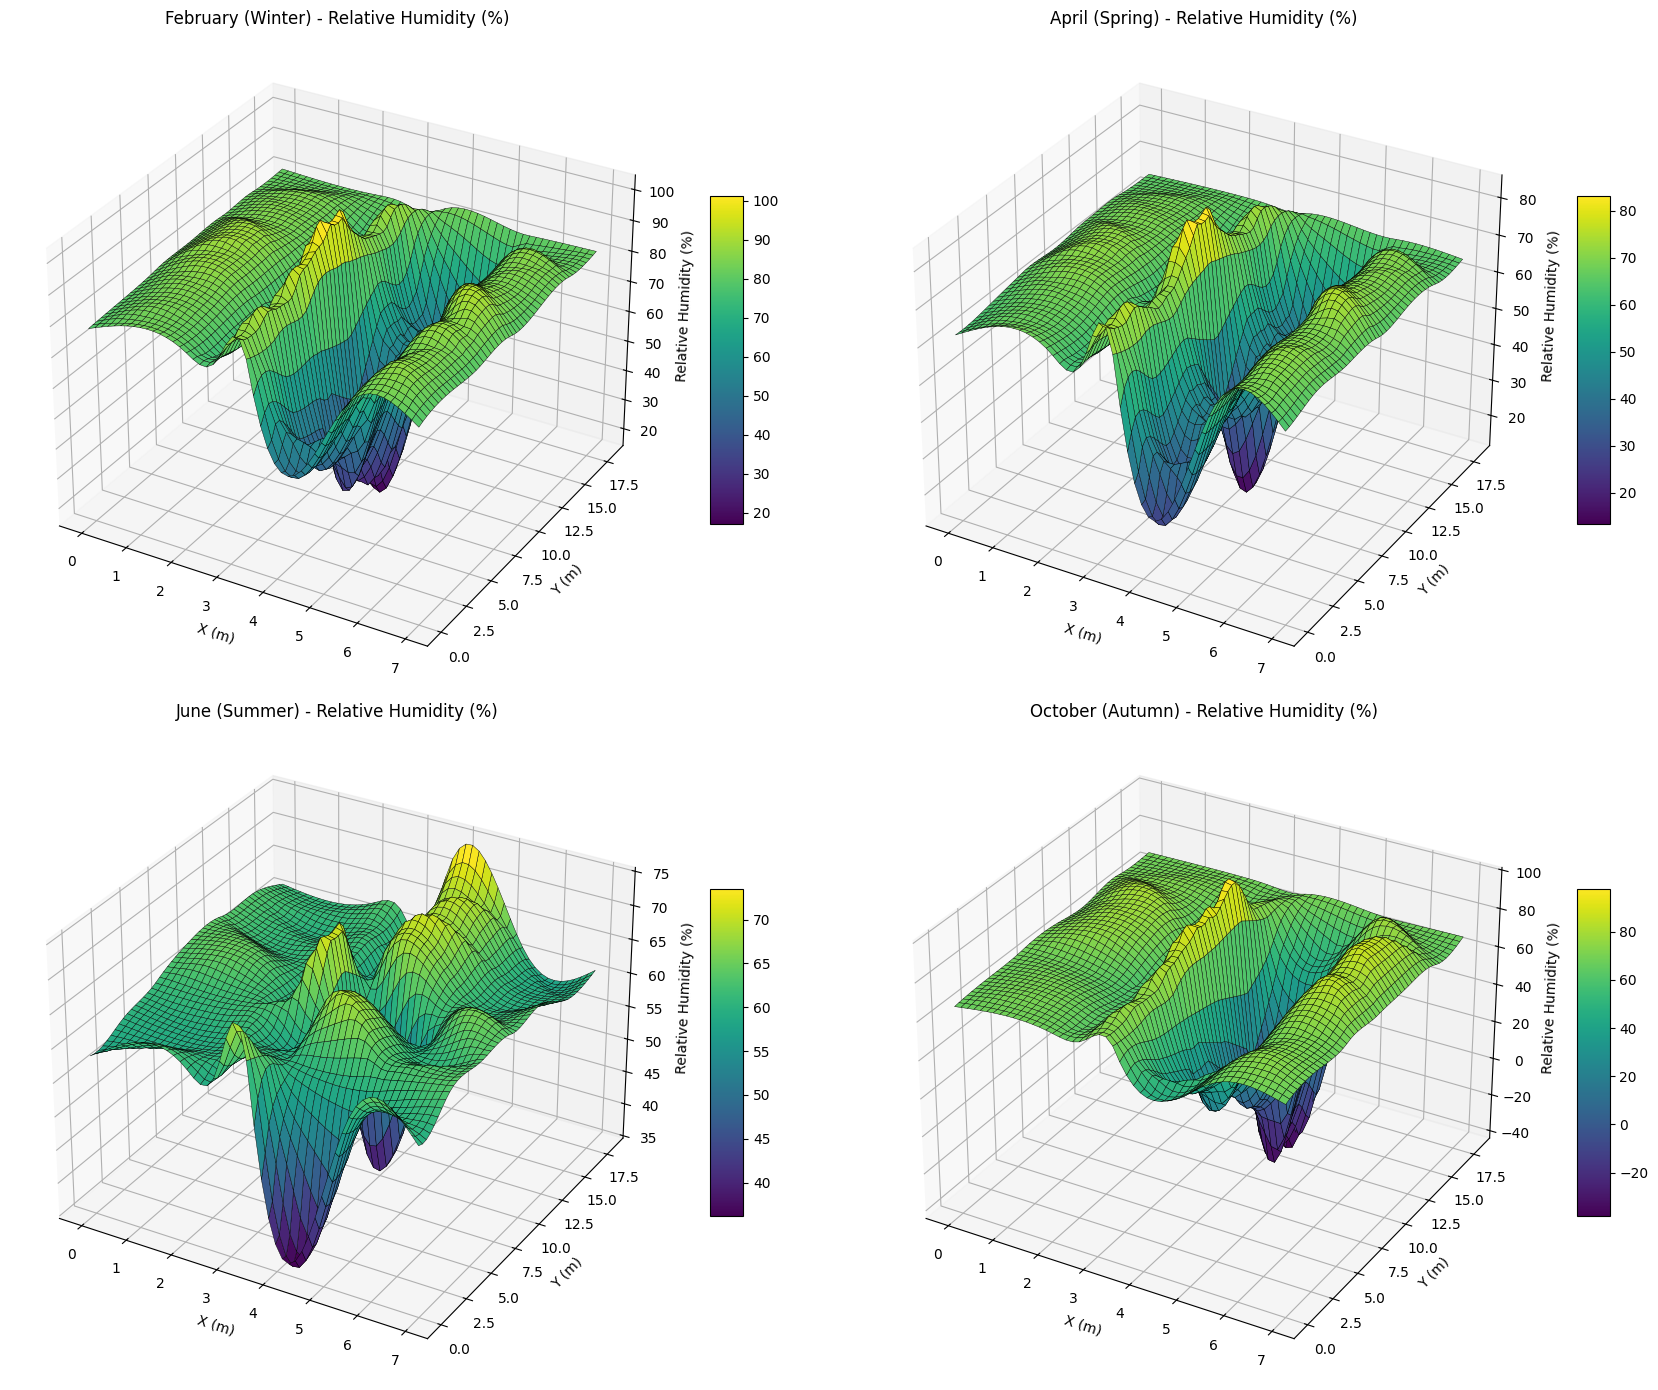

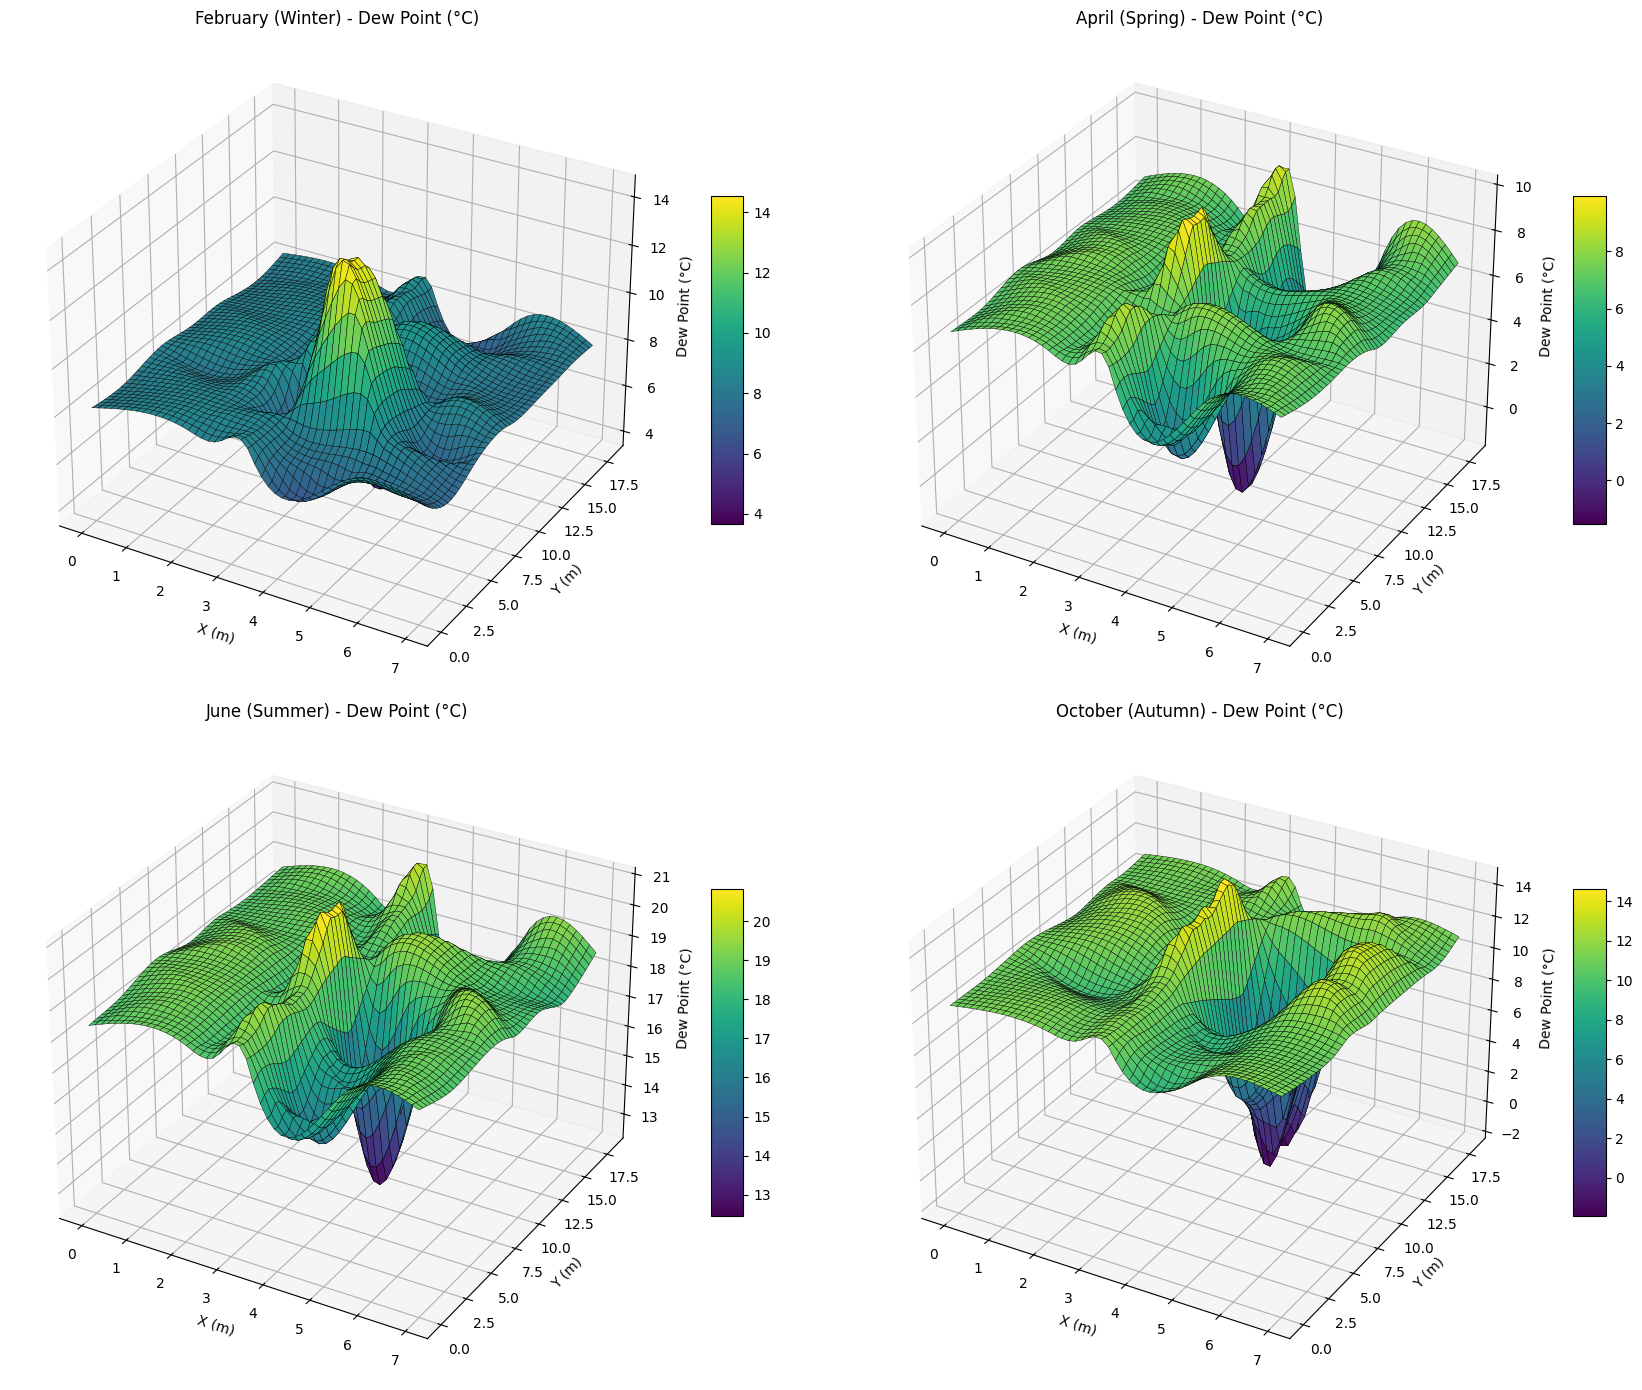

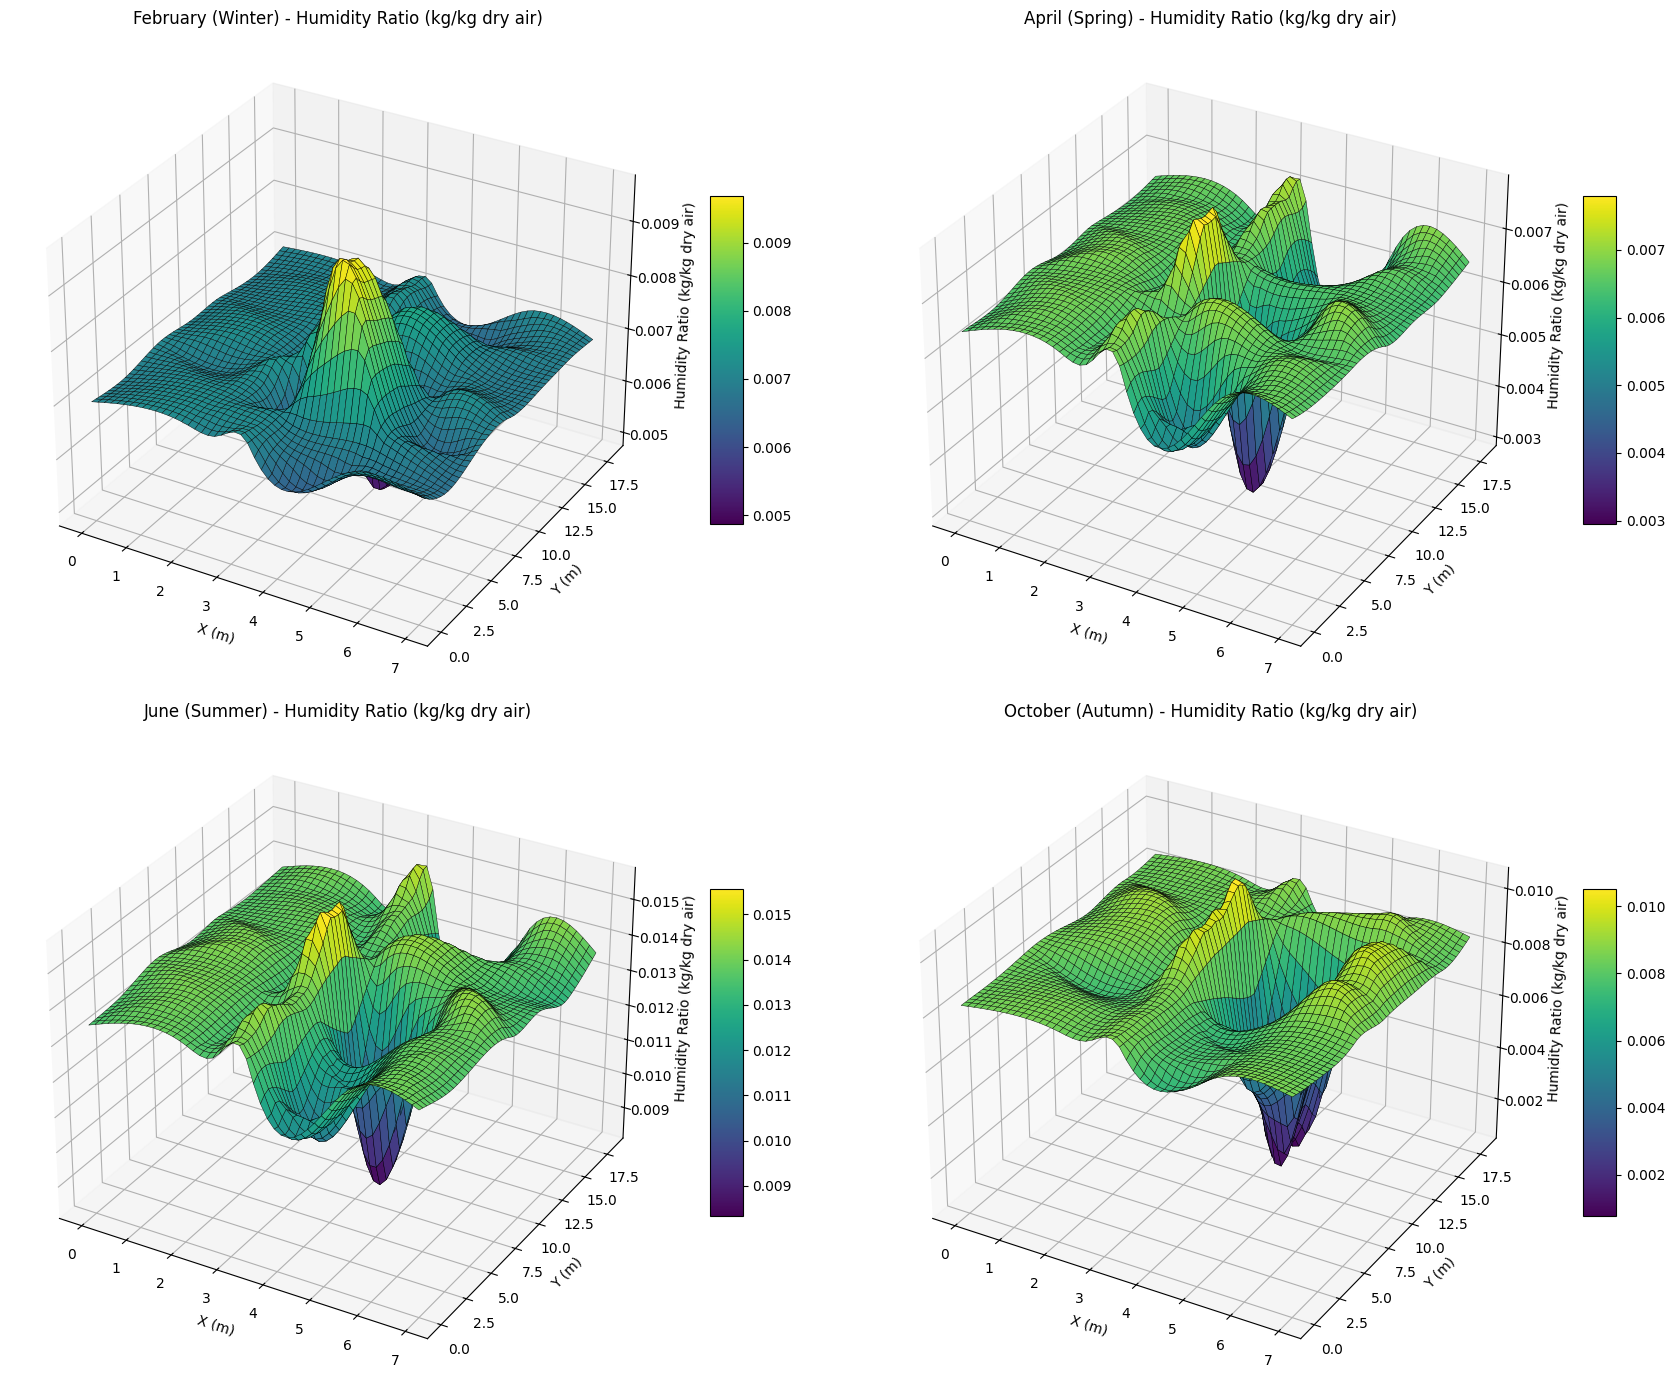

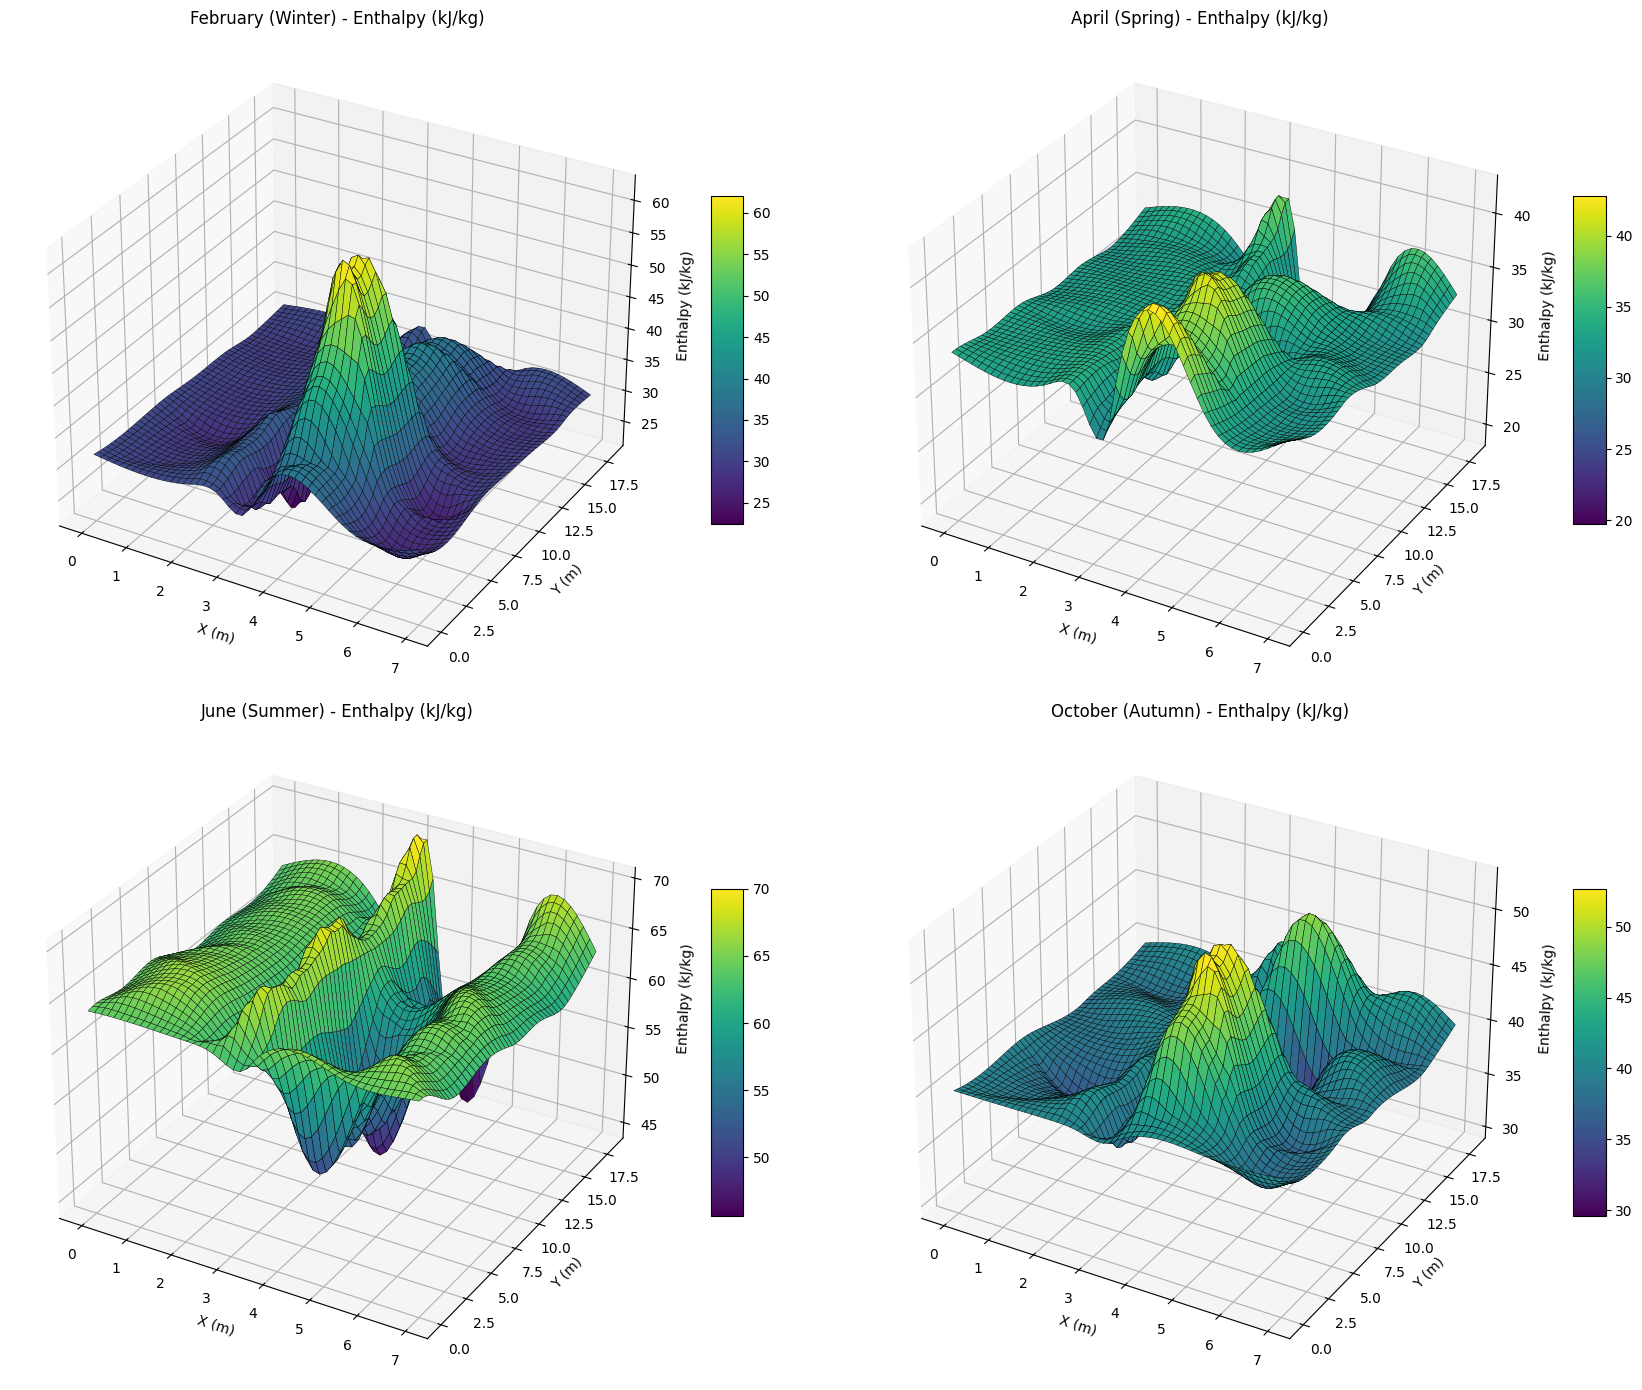

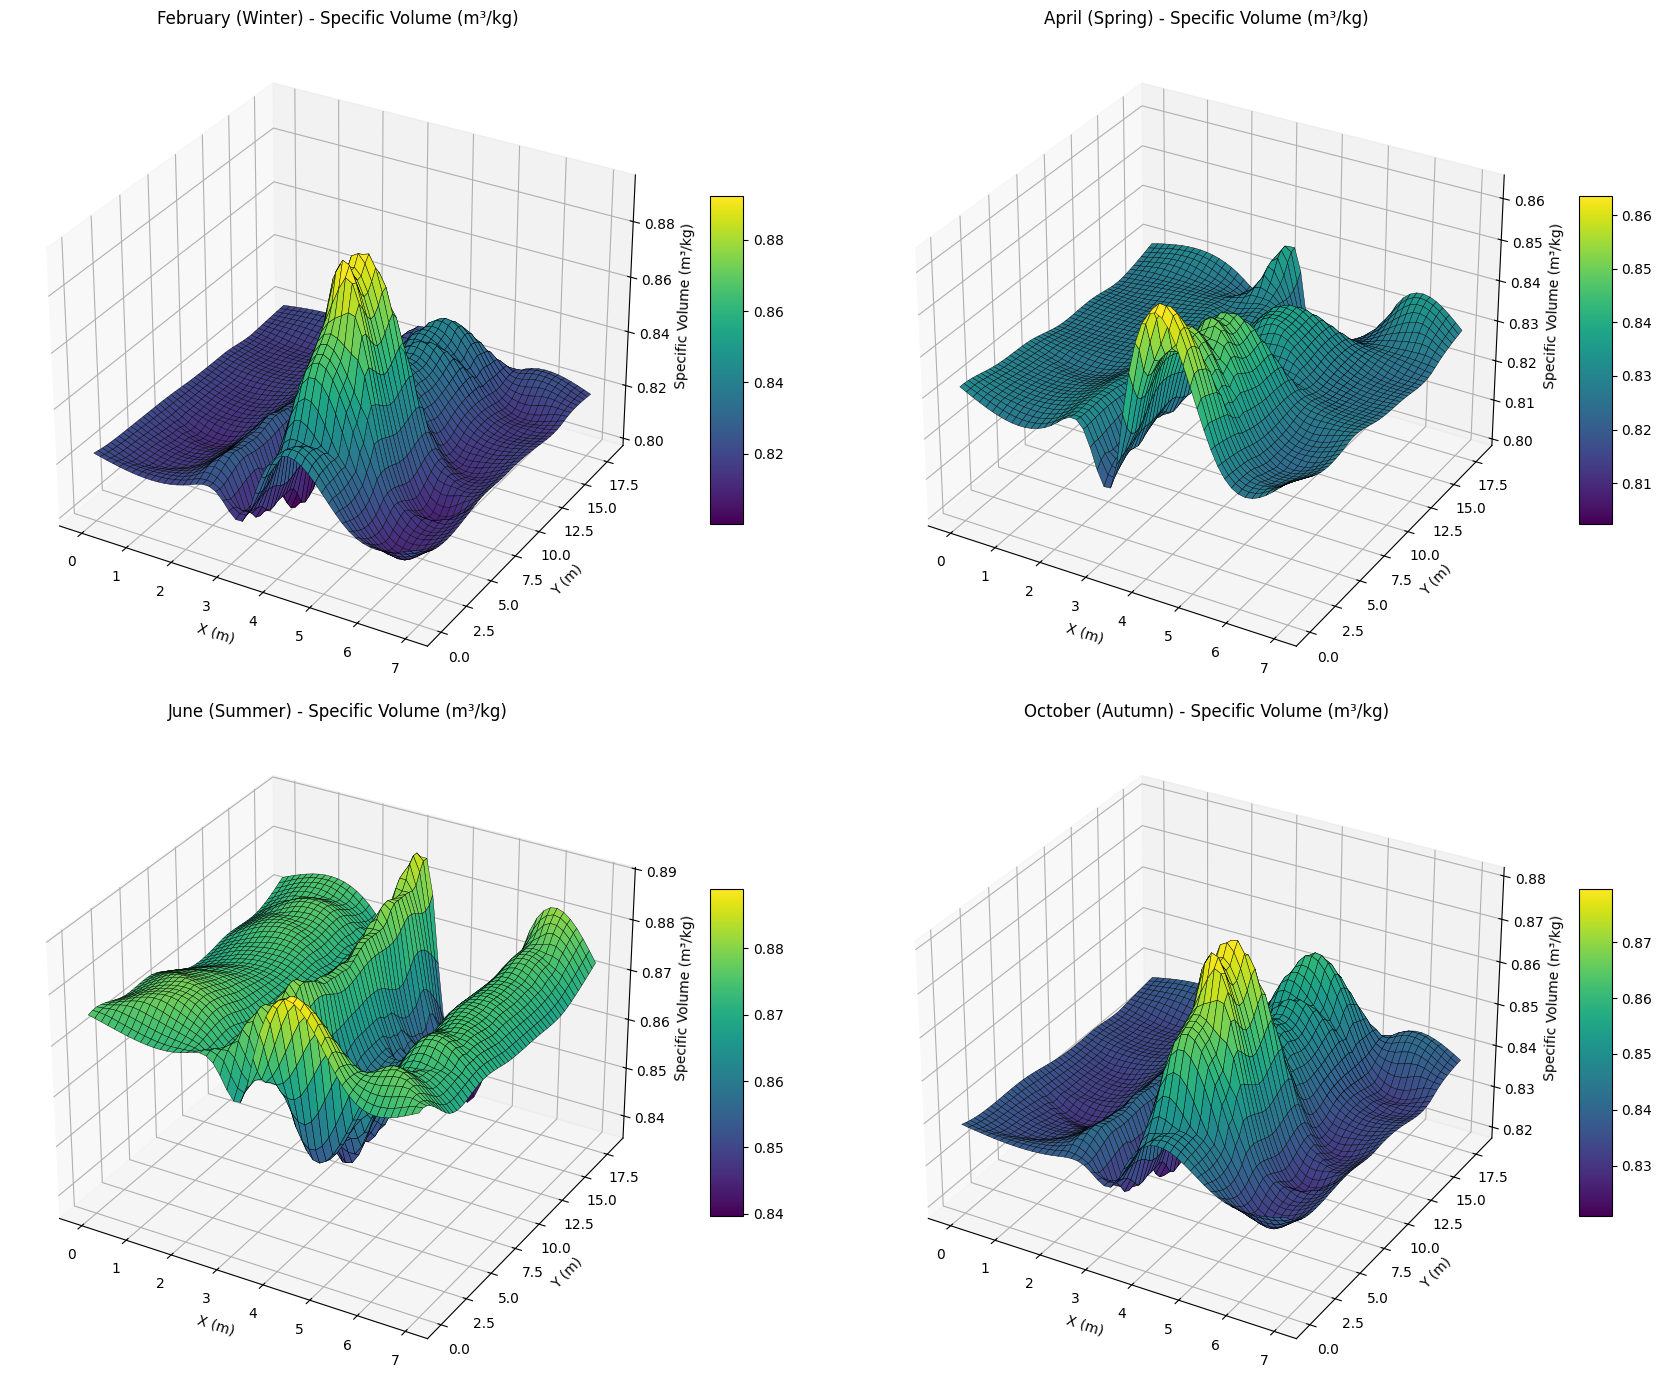

In [2]:


# ========== CONFIGURATION ==========
sensor_coord_file = r'/Users/akintanoreofeoluwa/Library/CloudStorage/OneDrive-MichiganStateUniversity/DT SENSOR Placement Paper/csv_data/sensors_location_coordinates.xlsx'

monthly_files = {
    'February (Winter)': 'Smartfarm data_Feb_Winter.xlsx',
    'April (Spring)': 'Smartfarm_April_2020.xlsx',
    'June (Summer)': 'Smartfarm data_June_summer.xlsx',
    'October (Autumn)': 'Smartfarm data_-October_Autumn.xlsx'
}

variables = ['Temperature', 'Relative Humidity', 'Dew Point', 'Humidity Ratio', 'Enthalpy', 'Specific Volume']
titles = ['Temperature (°C)', 'Relative Humidity (%)', 'Dew Point (°C)',
          'Humidity Ratio (kg/kg dry air)', 'Enthalpy (kJ/kg)', 'Specific Volume (m³/kg)']

# ========== FUNCTIONS ==========
def compute_psychrometrics(T_C, RH):
    P_atm = 101.325  # kPa
    T_K = T_C + 273.15
    A = 6.1121
    m = 17.62
    Tn = 243.12

    Pws = A * np.exp((m * T_C) / (T_C + Tn))
    Pw = RH / 100.0 * Pws

    alpha = np.log(Pw / A)
    dew_point = (Tn * alpha) / (m - alpha)
    W = 0.622 * (Pw / (P_atm * 10 - Pw))
    h = 1.006 * T_C + W * (2501 + 1.86 * T_C)
    sv = (0.287042 * T_K * (1 + 1.6078 * W)) / P_atm

    return dew_point, W, h, sv

def prepare_psychro_merged(df, sensor_coords):
    psychro_vars, avg_temp_hum = [], []
    for col in [c.split('.')[0] for c in df.columns if '. Temp' in c]:
        temp_col = f'{col}. Temp. (°C)'
        hum_col = f'{col}. Humidity (%)'
        if temp_col in df.columns and hum_col in df.columns:
            T, RH = df[temp_col], df[hum_col]
            dp, W, h, sv = compute_psychrometrics(T, RH)
            psychro_vars.append({'Sensor': col, 'Dew Point': dp.mean(), 'Humidity Ratio': W.mean(), 'Enthalpy': h.mean(), 'Specific Volume': sv.mean()})
            avg_temp_hum.append({'Sensor': col, 'Temperature': T.mean(), 'Relative Humidity': RH.mean()})
    df_psychro = pd.DataFrame(psychro_vars)
    df_avg = pd.DataFrame(avg_temp_hum)
    merged = pd.merge(sensor_coords, df_psychro, on='Sensor')
    return pd.merge(merged, df_avg, on='Sensor')

def plot_selected_months(selected_data, variable, label):
    fig = plt.figure(figsize=(18, 14))
    for i, (month_label, data) in enumerate(selected_data.items()):
        x, y, z = data['X'].values, data['Y'].values, data[variable].values
        grid_x, grid_y = np.mgrid[min(x):max(x):50j, min(y):max(y):50j]
        grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')
        ax = fig.add_subplot(2, 2, i + 1, projection='3d')
        surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', edgecolor='k', linewidth=0.3)
        ax.set_title(f'{month_label} - {label}')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_zlabel(label)
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.show()

# ========== MAIN EXECUTION ==========
sensor_coords = pd.read_excel(sensor_coord_file)
sensor_coords['Sensor'] = sensor_coords['Sensor'].str.strip()

seasonal_data = {}

for label, filepath in monthly_files.items():
    df = pd.read_excel(filepath, sheet_name="Sheet1")
    df.columns = df.columns.str.strip().str.replace('  ', ' ', regex=False)
    df['Date/ Time'] = pd.to_datetime(df['Date/ Time'])
    merged = prepare_psychro_merged(df, sensor_coords)
    seasonal_data[label] = merged

# Plot each variable across selected months
for var, title in zip(variables, titles):
    plot_selected_months(seasonal_data, var, title)


In [ ]:

# === CONFIGURATION ===
input_folder = r"/Users/akintanoreofeoluwa/Library/CloudStorage/OneDrive-MichiganStateUniversity/DT SENSOR Placement Paper/csv_data/psychrometric_outputs/Thompson"
output_folder = os.path.join(input_folder, "thompson_mean_crossing_cleaned")
os.makedirs(output_folder, exist_ok=True)

combined_files = [f for f in os.listdir(input_folder) if f.endswith('_Combined_FULL.csv')]
if not combined_files:
    print("⚠️ No combined files found.")
all_results = []

random.seed(10)

# === Thompson Sampling Using Mean Crossings as Reward ===
def thompson_sampling_mean_crossing(df):
    N, d = df.shape
    if N == 0 or d == 0:
        return [], Counter()

    selected_sensors = []
    rewards_1 = [0] * d
    rewards_0 = [0] * d

    # Precompute mean thresholds
    thresholds = df.mean()

    # Determine if each value is either above or below the mean
    crossing_flags = (df.gt(thresholds, axis=1) | df.lt(thresholds, axis=1)).astype(int)

    for n in range(N):
        ad = 0
        max_beta = 0
        for i in range(d):
            beta_sample = random.betavariate(rewards_1[i] + 1, rewards_0[i] + 1)
            if beta_sample > max_beta:
                ad = i
                max_beta = beta_sample
        selected_sensors.append(ad)

        reward = crossing_flags.iloc[n, ad]  # 1 if crossing, else 0
        if reward == 1:
            rewards_1[ad] += 1
        else:
            rewards_0[ad] += 1

    counts = Counter(selected_sensors)
    return counts.most_common(), counts

# === Process All Files ===
excel_path = os.path.join(output_folder, "All_Seasons_Top_Sensors.xlsx")
csv_path = os.path.join(output_folder, "All_Seasons_Top_Sensors.csv")

with pd.ExcelWriter(excel_path, engine='xlsxwriter') as writer:

    for file in combined_files:
        season = file.replace('_Combined_FULL.csv', '')
        print(f"\n🔍 Processing: {season}")

        df = pd.read_csv(os.path.join(input_folder, file))
        df.columns = df.columns.str.replace(r"[\.\s]+", "", regex=True)

        if df.empty:
            print(f"⚠️ Skipping {season} due to empty data.")
            continue

        season_results = []

        for param in ['Temperature', 'Humidity', 'DewPoint', 'HumidityRatio', 'Enthalpy', 'SpecificVolume']:
            param_cols = [col for col in df.columns if param.lower() in col.lower()]
            if not param_cols:
                continue

            clean_param_cols = []
            for col in param_cols:
                match = re.search(r'([A-Ha-h][0-9]+)', col)
                if match:
                    clean_param_cols.append(col)

            if not clean_param_cols:
                continue

            param_df = df[clean_param_cols]

            # === Clean Data ===
            param_df = param_df.dropna()
            param_df = param_df[(param_df != 0).any(axis=1)]

            if param_df.empty:
                print(f"⚠️ Skipping {param} in {season} due to invalid or empty sensor data.")
                continue

            # === Run Thompson Sampling ===
            top_sensors, full_counts = thompson_sampling_mean_crossing(param_df)

            if not top_sensors:
                continue

            sensor_mapping = {idx: re.search(r'([A-Ha-h][0-9]+)', col).group(1) for idx, col in enumerate(clean_param_cols)}

            for rank, (idx, count) in enumerate(top_sensors, start=1):
                result_row = {
                    'Season': season,
                    'Parameter': param,
                    'Rank': rank,
                    'Sensor': sensor_mapping.get(idx, f"Sensor{idx}"),
                    'Selection Count': count
                }
                season_results.append(result_row)
                all_results.append(result_row)

            # === Plot Selection Frequency ===
            plt.figure(figsize=(10, 6))
            plt.bar([sensor_mapping[i] for i in full_counts.keys()], full_counts.values(), color='teal')
            plt.title(f"{season} - {param} Sensor Selection (Mean Crossings Only)")
            plt.xlabel("Sensor ID")
            plt.ylabel("Selection Count")
            plt.tight_layout()
            # plt.show()  # Enable for visual debugging

        if season_results:
            pd.DataFrame(season_results).to_excel(writer, sheet_name=season[:31], index=False)

# === Save Combined Output ===
if all_results:
    final_df = pd.DataFrame(all_results)
    final_df.to_csv(csv_path, index=False)

print(f"\n All results saved to:\n{excel_path}\n{csv_path}")
print("Thompson Sampling with mean crossing rewards and cleaned data completed.")
